# Summarization Model Comparison

This code base is example of how perform summarization and score them.  You'll need a human created summarization dataset that can be used to either fine tune a foundational model or provide as few shot exemplars.  

[TODO]
- Add a fine tune model to show the difference in scores between a foundational model and fine tuned model.  Expectations is that fine tune model will have figher scores.  

In [47]:
import pandas as pd
import os
import re

In [92]:
from vertexai.language_models import TextGenerationModel

In [ ]:
## Import configuration

import yaml

config_file = '/Users/jamesharding/repo/ml-gcp/config/p1.yaml'

def get_variables(config_file):
  with open(config_file, 'r') as f:
    data = yaml.safe_load(f)
  return data

var = get_variables(config_file)

for key,val in var.items():
  exec(key + '=val')

## Validate configuration
# verify parameters are set
if not (PROJECT_ID and REGION and GCS_BUCKET):
    from absl import logging
    logging.error('Please set all required parameters.')
else:
    print('Parameters set:')
    print('\t\tROJECT_ID:\t {}'.format(PROJECT_ID))
    print('\t\tPROJECT_NUMBER:\t {}'.format(PROJECT_NUMBER))
    print('\t\tREGION:\t\t {}'.format(REGION))
    print('\t\tGCS_BUCKET:\t {}'.format(GCS_BUCKET))

## Data Processing

The data can be downloaded from [ucsb.box.com](https://ucsb.box.com/s/ap23l8gafpezf4tq3wapr6u8241zz358)

In [68]:
# read data into a dataframe

df = pd.read_csv(r'wikihowAll.csv')
df = df.astype(str)
rows, columns = df.shape

In [181]:
# This is a huge dataset, let's test with a small subset
rows = 30
raw_df = df.head(rows)
print(raw_df.shape)
print(raw_df.head())    


(30, 3)
                                            headline  \
0  \nKeep related supplies in the same area.,\nMa...   
1  \nCreate a sketch in the NeoPopRealist manner ...   
2  \nGet a bachelor’s degree.,\nEnroll in a studi...   
3  \nStart with some experience or interest in ar...   
4  \nKeep your reference materials, sketches, art...   

                                    title  \
0          How to Be an Organized Artist1   
1  How to Create a Neopoprealist Art Work   
2      How to Be a Visual Effects Artist1   
3           How to Become an Art Investor   
4          How to Be an Organized Artist2   

                                                text  
0   If you're a photographer, keep all the necess...  
1   See the image for how this drawing develops s...  
2   It is possible to become a VFX artist without...  
3   The best art investors do their research on t...  
4   As you start planning for a project or work, ...  


In [182]:
# function to cleans the data
def clean_text(df, rows):
    
    # create new dataframe
    dataset = pd.DataFrame(columns=['article_name', 'article','token_size', 'abstract'])

    for row in range(rows):
        abstract = df.loc[row, "headline"]      # headline is the column representing the summary sentences
        article = df.loc[row, "text"]

        if len(abstract) < (0.75*len(article)):
            # remove extra commas in abstracts
            abstract = abstract.replace(".,",".")
        
            # remove extra commas in articles
            article = re.sub(r'[.]+[\n]+[,]',".\n", article)

            # article names are created using the alphanumeric charachters from the article titles.
            article_name = df.loc[row, "title"]
            article_name = "".join(x for x in article_name if x.isalnum())

            new_row = pd.DataFrame({'article_name': article_name, 'article': article, 'token_size': round(len(article)/4), 'abstract': abstract},index =[0])
            dataset = pd.concat([new_row, dataset]).reset_index(drop = True)

    return dataset

In [298]:
# Process the raw text
data_df = clean_text(raw_df,rows)

In [299]:
print(data_df.shape)
print(data_df.head(10))

(28, 4)
                              article_name  \
0          HowtoKnowwhenYouHaveTooManyPets   
1                   HowtoKeepYourPetsHappy   
2  HowtoLeaveYourPetsAloneWhileonVacation1   
3              HowtoBeaGoodPetOwnerforKids   
4                    HowtoBeAnimalFriendly   
5             HowtoBeaResponsiblePetParent   
6                           HowtoBeHealthy   
7            HowtoCopewithaBedriddenParent   
8              HowtoDealWithFaintingSpells   
9               HowtoFindtheNearestCasino5   

                                             article token_size  \
0   Cleaning, feeding, grooming, exercising, and ...       2525   
1   Even if you have a busy schedule and return h...        457   
2   All pets are different and have unique person...        521   
3   You should start by providing the necessities...       1830   
4   If you just can't, reduce meat from your meal...        306   
5   This is a very fun part of having a pet. Choo...        640   
6   Adult humans

## PaLM 2 Summarization

In [93]:
from vertexai.language_models import TextGenerationModel
generation_model = TextGenerationModel.from_pretrained("text-bison@001")

In [95]:
def get_summary(row):
    prompt = f"""Generate a summary of the following article.\n\n
            article: {row}
            summary:
              """
    return generation_model.predict(
        prompt=prompt,
    ).text


In [300]:
generic_summmary = data_df.copy()
generic_summmary["summary_prediction"] = generic_summmary["article"].apply(get_summary)

In [101]:
from rouge import Rouge

ROUGE = Rouge()

In [357]:
def plot_results(dataframe, metric_type, metric, column, title):
    
    # get the metric_type label
    if metric_type == "rouge-1":
        metric_type_label = "Rouge-1"
    elif metric_type == "rouge-2":
        metric_type_label = "Rouge-2"
    elif metric_type == "rouge-l":
        metric_type_label = "Rouge-L"

    # get the metric label
    if metric == "r":
        metric_label = "Recall"
    elif metric == "p":
        metric_label = "Precision"
    elif metric == "f":
        metric_label = "F1"

    # add the metric type to the title
    title = f"{title} {metric_type_label} {metric_label}"

    # get the data
    data = pd.Series(dataframe.loc[:, "scores"].apply(lambda x: x[metric_type][metric]))

    # plot the data
    data.plot.hist(grid=True, bins=20, rwidth=0.9,
        color='#607c8e')
    plt.title(title)
    plt.xlabel(metric_label)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

In [272]:
# Get rouge scores for all rows
def get_rouge(df):
    
    rows = df.shape[0]
     
    # create new dataframe
    dataset = pd.DataFrame(columns=["article_name", "scores"])
     
    for row in range(rows):
        candidate = df.loc[row, "summary_prediction"]
        reference = df.loc[row, "abstract"]
        article_name = df.loc[row, "article_name"]
        
        # get rouge scores
        scores = ROUGE.get_scores(candidate, reference)
        
        # create temporary dataframe to store the scores
        new_row = pd.DataFrame({"article_name": article_name, "scores": scores},index =[0])

        # append the temporary dataframe to the dataset  
        dataset = pd.concat([new_row, dataset]).reset_index(drop = True)
    return dataset

In [301]:
results_df = get_rouge(generic_summmary)

In [302]:
results_df[:]

,article_name,scores
0,HowtoBeanOrganizedArtist1,"{'rouge-1': {'r': 0.19696969696969696, 'p': 0...."
1,HowtoCreateaNeopoprealistArtWork,"{'rouge-1': {'r': 0.12941176470588237, 'p': 0...."
2,HowtoBeaVisualEffectsArtist1,"{'rouge-1': {'r': 0.2647058823529412, 'p': 0.2..."
3,HowtoBecomeanArtInvestor,"{'rouge-1': {'r': 0.10126582278481013, 'p': 0...."
4,HowtoBeanOrganizedArtist2,"{'rouge-1': {'r': 0.27450980392156865, 'p': 0...."
5,HowtoBeanOrganizedArtist3,"{'rouge-1': {'r': 0.3125, 'p': 0.2678571428571..."
6,HowtoBeaVisualEffectsArtist2,"{'rouge-1': {'r': 0.36363636363636365, 'p': 0...."
7,HowtoBeaVisualEffectsArtist3,"{'rouge-1': {'r': 0.3684210526315789, 'p': 0.1..."
8,HowtoBeGoodatImprovisation,"{'rouge-1': {'r': 0.27586206896551724, 'p': 0...."
9,HowtoAlwaysCatchPopCultureReferences1,"{'rouge-1': {'r': 0.2962962962962963, 'p': 0.4..."


In [303]:
# Determine how to extract the scores from the dictionary stored in a dataframe column
#results_df.loc[:, "scores"].apply(lambda x: x["rouge-1"]["r"])
results_df.loc[:, "scores"].apply(lambda x: x["rouge-1"]["p"])

0     0.464286
1     0.379310
2     0.219512
3     0.400000
4     0.274510
5     0.267857
6     0.121212
7     0.122807
8     0.363636
9     0.444444
10    0.200000
11    0.125000
12    0.418182
13    0.419355
14    0.305556
15    0.261905
16    0.209302
17    0.321429
18    0.137931
19    0.207547
20    0.274510
21    0.196078
22    0.317073
23    0.263158
24    0.372549
25    0.127273
26    0.075758
27    0.409091
Name: scores, dtype: float64

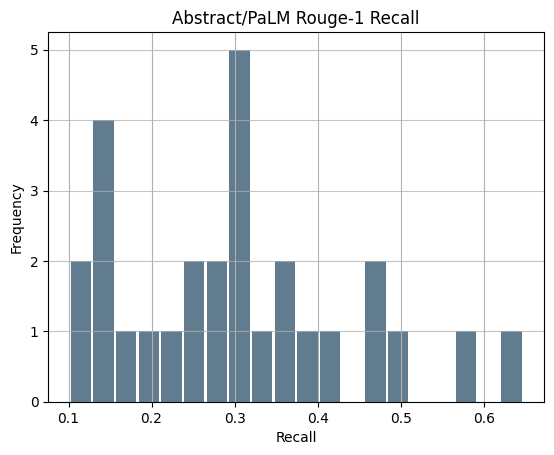

In [360]:
plot_results(results_df, "rouge-1", "r", "scores", "Abstract/PaLM")

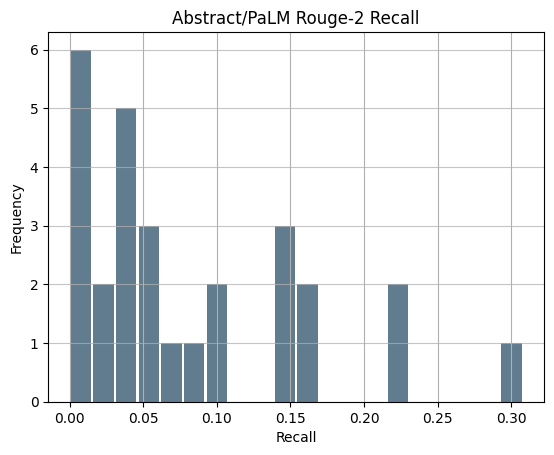

In [361]:
plot_results(results_df, "rouge-2", "r", "scores", "Abstract/PaLM")

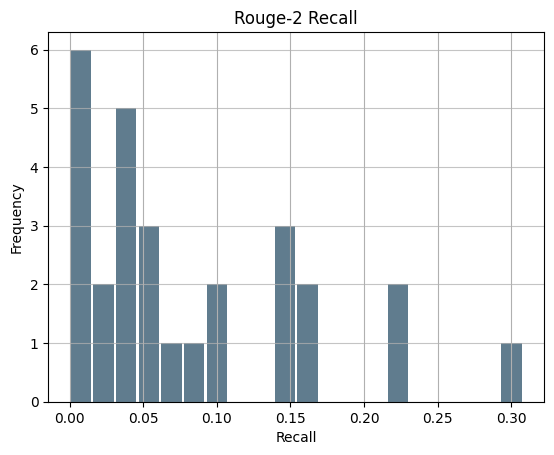

In [305]:
bigram_overlap = pd.Series(results_df.loc[:, "scores"].apply(lambda x: x["rouge-2"]["r"]))
bigram_overlap.plot.hist(grid=True, bins=20, rwidth=0.9,
                   color='#607c8e')
plt.title('Rouge-2 Recall')
plt.xlabel('Recall')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)

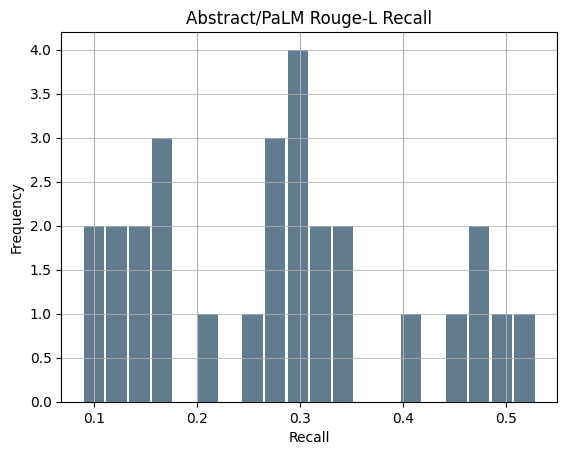

In [362]:
plot_results(results_df, "rouge-l", "r", "scores", "Abstract/PaLM")

## Shorter Summaries

In [308]:
def get_short_summary(row):
    prompt = f"""Provide a very short, maximum four sentences, summary for the following article.\n\n
            article: {row}
            summary:
              """
    return generation_model.predict(
        prompt=prompt, temperature=0.9, max_output_tokens=1024, top_k=40, top_p=0.9
    ).text

In [309]:
short_summmary = data_df.copy()
short_summmary["summary_prediction"] = short_summmary["article"].apply(get_short_summary)

In [310]:
results_short_df = get_rouge(short_summmary)

In [311]:
results_short_df.loc[:, "scores"].apply(lambda x: x["rouge-1"]["r"])

0     0.151515
1     0.129412
2     0.235294
3     0.227848
4     0.254902
5     0.208333
6     0.272727
7     0.210526
8     0.310345
9     0.351852
10    0.588235
11    0.127660
12    0.229730
13    0.078947
14    0.459459
15    0.352941
16    0.409091
17    0.555556
18    0.333333
19    0.235294
20    0.260870
21    0.078125
22    0.370370
23    0.133333
24    0.200000
25    0.250000
26    0.263158
27    0.173913
Name: scores, dtype: float64

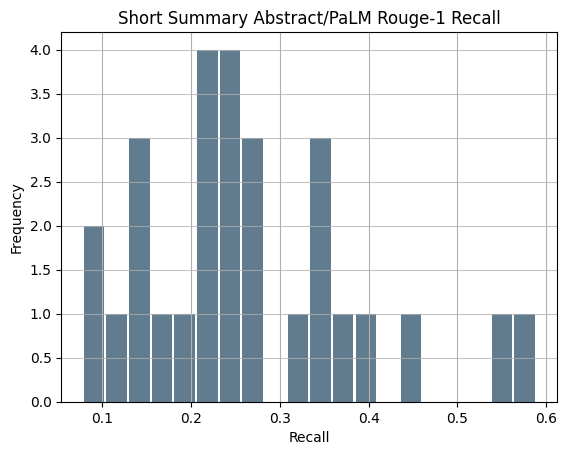

In [363]:
plot_results(results_short_df, "rouge-1", "r", "scores", "Short Summary Abstract/PaLM")

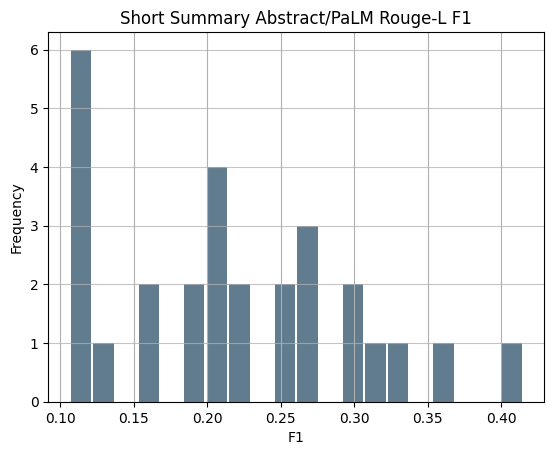

In [364]:
plot_results(results_short_df, "rouge-l", "f", "scores", "Short Summary Abstract/PaLM")

# Compare PaLM to Gemini Summarizations

In [323]:
import vertexai 

from vertexai.preview.generative_models import (
    GenerationConfig,
    GenerativeModel,
)

vertexai.init(project=PROJECT_ID, location=REGION)



model = GenerativeModel("gemini-pro")

def get_gemini_summary(row):
    
    generation_config = GenerationConfig(
    temperature=0.9,
    top_p=1.0,
    top_k=32,
    candidate_count=1,
    max_output_tokens=8192,)

    prompt = f"""Generate a summary of the following article.\n\n
            article: {row}
            summary:
              """
    return model.generate_content(
        prompt,
        generation_config=generation_config,
        stream=False,
    ).text

In [325]:
model_comparison = data_df.copy()
model_comparison["gemini_prediction"] = model_comparison["article"].apply(get_gemini_summary)

In [326]:
def get_palm_summary(row):
    prompt = f"""Generate a summary of the following article.\n\n
            article: {row}
            summary:
              """
    return generation_model.predict(
        prompt=prompt, temperature=0.9, max_output_tokens=1024, top_k=32, top_p=1.0
    ).text

In [327]:
model_comparison["palm_prediction"] = model_comparison["article"].apply(get_palm_summary)

In [329]:
def get_rouge(df, _candidate, _reference):
    
    rows = df.shape[0]
     
    # create new dataframe
    dataset = pd.DataFrame(columns=["article_name", "scores"])
     
    for row in range(rows):
        candidate = df.loc[row, _candidate]
        reference = df.loc[row, _reference]
        article_name = df.loc[row, "article_name"]
        
        # get rouge scores
        scores = ROUGE.get_scores(candidate, reference)
        
        # create temporary dataframe to store the scores
        new_row = pd.DataFrame({"article_name": article_name, "scores": scores},index =[0])

        # append the temporary dataframe to the dataset  
        dataset = pd.concat([new_row, dataset]).reset_index(drop = True)
    return dataset

In [331]:
model_comparison_results = get_rouge(model_comparison, "palm_prediction", "gemini_prediction")

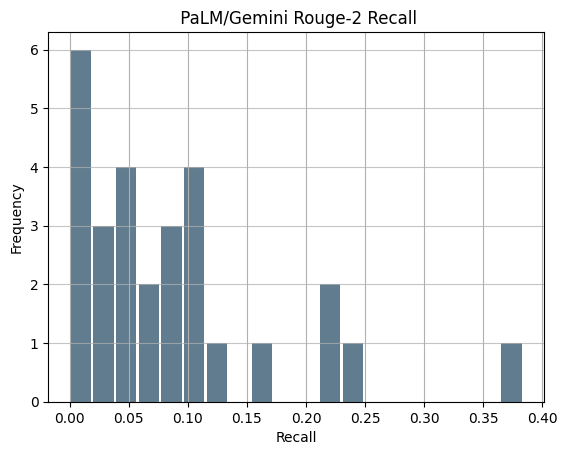

In [365]:
plot_results(model_comparison_results, "rouge-2", "r", "scores", " PaLM/Gemini")

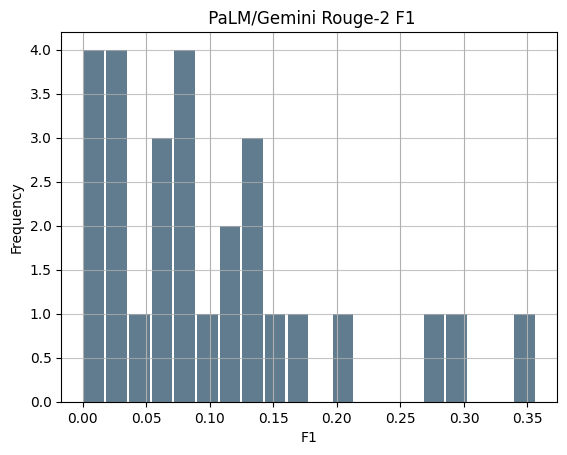

In [366]:
plot_results(model_comparison_results, "rouge-2", "f", "scores", " PaLM/Gemini")

In [336]:
model_comparison_results_0 = get_rouge(model_comparison, "abstract", "gemini_prediction")

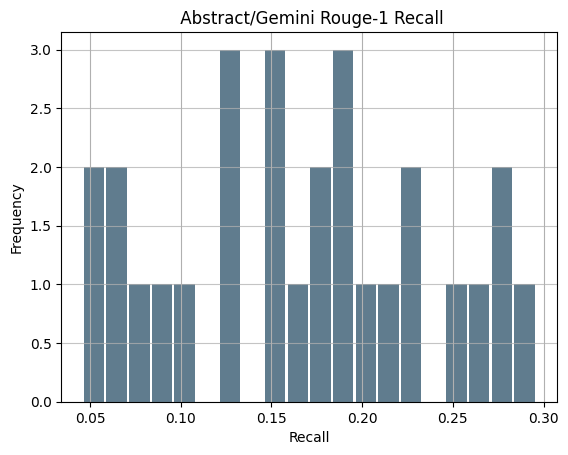

In [368]:
plot_results(model_comparison_results_0, "rouge-1", "r", "scores", " Abstract/Gemini")

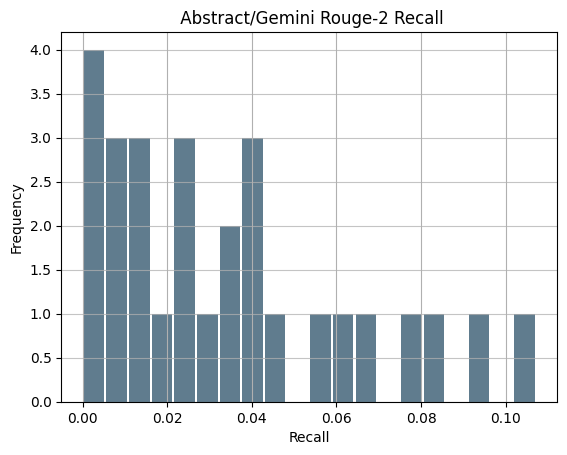

In [369]:
plot_results(model_comparison_results_0, "rouge-2", "r", "scores", " Abstract/Gemini")

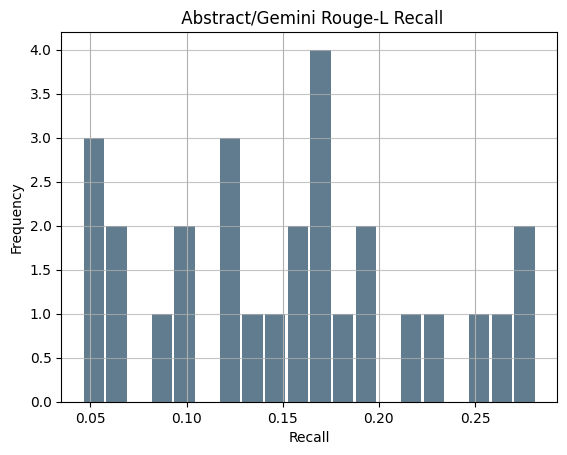

In [370]:
plot_results(model_comparison_results_0, "rouge-l", "r", "scores", " Abstract/Gemini")

- ROUGE-2 F1-score above 0.4 is generally considered good. 
- ROUGE-L F1-score around 0.3 to 0.4 may be considered low. 
- ROUGE-L F1-score around 0.4 to 0.5 may be considered moderate. 
- ROUGE-L F1-score above 0.5 is generally considered good.

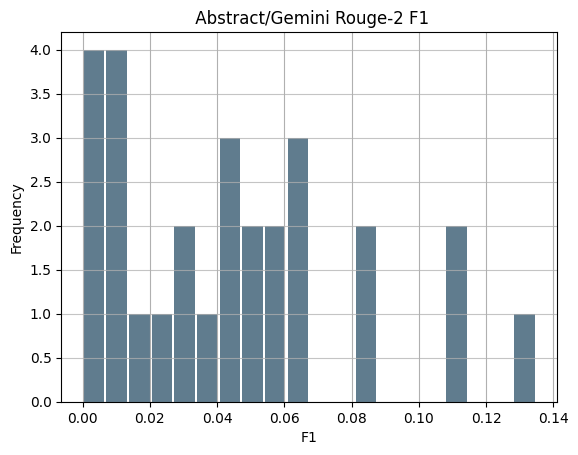

In [371]:
plot_results(model_comparison_results_0, "rouge-2", "f", "scores", " Abstract/Gemini")

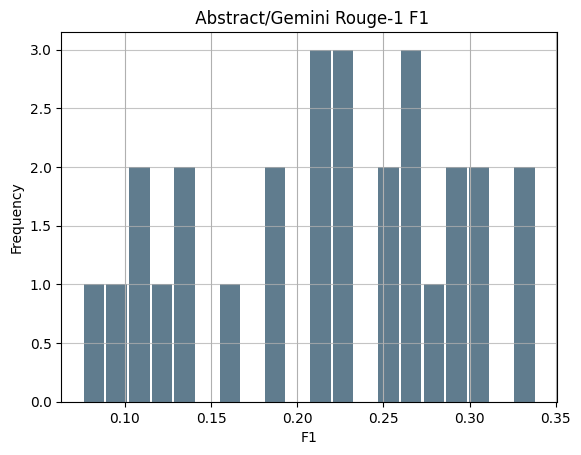

In [372]:
plot_results(model_comparison_results_0, "rouge-1", "f", "scores", " Abstract/Gemini")